In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Get random phage/host embeddings and interactions
Considering L_phage and L_host as 1

In [2]:
# need to get a lower number of samples to train locally

def get_random_embeddings_and_metadata(n_host=2800, n_phage=30000, host_dim=10, embedding_dim=4096):
    phage_ids = ['P' + str(i) for i in range(n_phage)]
    phage_embeddings = np.random.randn(n_phage, 1, embedding_dim).astype(np.float32)
    
    host_ids = ['H' + str(i) for i in range(n_host)]
    host_embeddings = np.random.randn(n_host, host_dim, embedding_dim).astype(np.float32)
    
    positive_pairs = []
    negative_pairs = []
    
    with tqdm.tqdm(total=len(phage_ids), desc="Pos/Neg Pairs") as pbar:
        for i in range(len(phage_ids)):
            pos_rand = np.random.randint(1, 6)
            neg_rand = np.random.randint(5, 11)

            random_hosts = np.random.choice(host_ids, pos_rand+neg_rand, replace=False)

            for j in range(pos_rand):
                positive_pairs.append((phage_ids[i], random_hosts[j]))
            for j in range(neg_rand):
                negative_pairs.append((phage_ids[i], random_hosts[j+pos_rand]))
            
            pbar.update(1)
            
    return [phage_ids, phage_embeddings, host_ids, host_embeddings, positive_pairs, negative_pairs]


In [3]:
phage_ids, phage_embeddings, host_ids, host_embeddings, positive_pairs, negative_pairs = get_random_embeddings_and_metadata(n_host=280, n_phage=3000)

Pos/Neg Pairs: 100% 3000/3000 [00:00<00:00, 13432.60it/s]


In [4]:
print(len(phage_ids))
print(phage_embeddings.shape)
print(len(host_ids))
print(host_embeddings.shape)
print(len(positive_pairs))
print(len(negative_pairs))

3000
(3000, 1, 4096)
280
(280, 10, 4096)
8994
22577


In [5]:
phage_embed_dict = {}
for i in range(len(phage_ids)):
    phage_embed_dict[phage_ids[i]] = phage_embeddings[i]
print(len(phage_embed_dict)) 

bact_embed_dict = {}
for i in range(len(host_ids)):
    bact_embed_dict[host_ids[i]] = host_embeddings[i]
print(len(bact_embed_dict))

3000
280


In [6]:
print(set(positive_pairs).intersection(set(negative_pairs)))

set()


In [7]:
print(len(set([x[0] for x in positive_pairs])))
print(len(set([x[1] for x in positive_pairs])))
print(len(set([x[0] for x in negative_pairs])))
print(len(set([x[1] for x in negative_pairs])))

3000
280
3000
280


In [8]:
positive_pairs_df = pd.DataFrame(positive_pairs, columns=['PhageID', 'HostID'])
positive_pairs_df

,PhageID,HostID
0,P0,H147
1,P1,H85
2,P2,H248
3,P2,H136
4,P3,H154
...,...,...
8989,P2998,H222
8990,P2999,H113
8991,P2999,H157
8992,P2999,H222


In [9]:
pos_train, pos_temp = train_test_split(positive_pairs_df, test_size=0.3, random_state=42)
pos_val, pos_test = train_test_split(pos_temp, test_size=0.5, random_state=42)
pos_train['Label'] = 1
pos_val['Label'] = 1
pos_test['Label'] = 1
print(pos_train.shape)
print(pos_val.shape)
print(pos_test.shape)

(6295, 3)
(1349, 3)
(1350, 3)


In [10]:
negative_pairs_df = pd.DataFrame(negative_pairs, columns=['PhageID', 'HostID'])
negative_pairs_df

,PhageID,HostID
0,P0,H129
1,P0,H135
2,P0,H244
3,P0,H120
4,P0,H189
...,...,...
22572,P2999,H193
22573,P2999,H103
22574,P2999,H32
22575,P2999,H102


In [11]:
neg_train, neg_temp = train_test_split(negative_pairs_df, test_size=0.3, random_state=42)
neg_val, neg_test = train_test_split(neg_temp, test_size=0.5, random_state=42)
neg_train['Label'] = 0
neg_val['Label'] = 0
neg_test['Label'] = 0
print(neg_train.shape)
print(neg_val.shape)
print(neg_test.shape)

(15803, 3)
(3387, 3)
(3387, 3)


In [12]:
train_ids = pd.concat([pos_train, neg_train])
val_ids = pd.concat([pos_val, neg_val])
test_ids = pd.concat([pos_test, neg_test])
print(train_ids.shape)
print(val_ids.shape)
print(test_ids.shape)

(22098, 3)
(4736, 3)
(4737, 3)


In [13]:
train_ids

,PhageID,HostID,Label
4695,P1560,H189,1
3413,P1146,H241,1
8362,P2790,H17,1
3590,P1202,H152,1
1514,P515,H9,1
...,...,...,...
11964,P1589,H275,0
21575,P2868,H172,0
5390,P718,H279,0
860,P112,H260,0


# Contrastive Learning Model

In [14]:
# Simple one-layer linear network, symmetrical for phage and host encodings, will have to flatten input

class SimpleEmbedding(nn.Module):
    def __init__(self, input_dim=4096, hidden_dim=1024, output_dim=512):
        super(SimpleEmbedding, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # print(torch.flatten(x, 1))
        return self.fc2(F.relu(self.fc1(torch.flatten(x, 1))))

In [15]:
# Euclidean distance, can also try to implement CLIP-like cosigne similarity matrix with cross-entropy loss

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, phage, bact, label):
        p_h_distance = torch.cdist(phage, bact)
        return 0.5*(torch.mean(label * torch.pow(p_h_distance, 2) 
                          + (1-label) * torch.pow(torch.clamp(self.margin - p_h_distance, min=0), 2)))

In [16]:
class PhageBactPairDataset(Dataset):
    def __init__(self, pair_df, phage_dict, bact_dict):
        self.pairs = pair_df[['PhageID', 'HostID']]
        self.labels = pair_df['Label'].values
        self.phages = phage_dict
        self.bacteria = bact_dict
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        pair = self.pairs.iloc[idx]
        label = self.labels[idx]
        # pair_phage = self.phages[np.where(self.phage_ids == pair['PhageID'].values)[0]]
        # pair_bact = self.bacteria[np.where(self.bact_ids == pair['HostID'].values)[0]]
        pair_phage = self.phages[pair['PhageID']]
        pair_bact = self.bacteria[pair['HostID']]
        
        return [torch.tensor(pair_phage, dtype=torch.float32), torch.tensor(pair_bact, dtype=torch.float32), torch.tensor(label)]

In [17]:
class TestDataset(Dataset):
    def __init__(self, id_list, embed_dict):
        self.id_list = id_list
        self.embeddings = embed_dict
        
    def __len__(self):
        return len(self.id_list)
    
    def __getitem__(self, idx):
        ID = self.id_list[idx]
        embed = self.embeddings[ID]
        return [ID, torch.tensor(embed, dtype=torch.float32)]  

In [18]:
def predict(loader, encoder):
    ids = []
    output_embeddings  = []
    with torch.no_grad():
        for batch in loader:
            ids.append(batch[0])
            output_embeddings.append(encoder(batch[1]))
    ids = np.concatenate(ids)
    output_embeddings = np.concatenate(output_embeddings)
    
    return ids, output_embeddings

In [40]:
def get_neighbor_list(phage_ids, phage_embeddings, bact_ids, bact_embeddings):
    sorted_neighbor_list = {}
    
    with torch.no_grad():
        all_distances = []
        for i in range(len(phage_ids)):
            distances = []
            for bact in bact_embeddings:
                # distances.append(torch.sqrt(torch.sum(torch.pow(phage_embeddings[i] - bact, 2), 1)))
                distances.append(np.linalg.norm(phage_embeddings[i] - bact))
            all_distances.append(distances)
    
    all_distances = np.array(all_distances)
    print(all_distances.shape)
    print(np.argsort(all_distances))

In [20]:
train_dataset = PhageBactPairDataset(pair_df=train_ids, phage_dict=phage_embed_dict, bact_dict=bact_embed_dict)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

phage_size = train_dataset[0][0].size()
bact_size = train_dataset[0][1].size()

val_dataset = PhageBactPairDataset(pair_df=val_ids, phage_dict=phage_embed_dict, bact_dict=bact_embed_dict)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

phage_encoder = SimpleEmbedding(input_dim=phage_size[0]*phage_size[1])
bacteria_encoder = SimpleEmbedding(input_dim=bact_size[0]*bact_size[1])
phage_optimizer = torch.optim.Adam(phage_encoder.parameters(), lr=0.001)
bacteria_optimizer = torch.optim.Adam(bacteria_encoder.parameters(), lr=0.001)
criterion = ContrastiveLoss()

training_loss = []
validation_loss = []
for epoch in range(10):
    with tqdm.tqdm(total=len(train_loader), desc='Epoch ' + str(epoch+1)) as pbar:
        batch_train_loss = 0
        count = 0
        for batch in train_loader:
            pbar.update(1)
            phage_batch_embed = phage_encoder(batch[0])
            bact_batch_embed = bacteria_encoder(batch[1])

            train_loss = criterion(phage_batch_embed, bact_batch_embed, batch[2])
            batch_train_loss += train_loss.item()
            count += 1

            phage_optimizer.zero_grad()
            bacteria_optimizer.zero_grad()
            train_loss.backward()
            phage_optimizer.step()
            bacteria_optimizer.step()
            
        training_loss.append(batch_train_loss/count)

        with torch.no_grad():
            batch_val_loss = 0
            count = 0
            for batch in val_loader:
                phage_batch_embed_val = phage_encoder(batch[0])
                bact_batch_embed_val = bacteria_encoder(batch[1])

                val_loss = criterion(phage_batch_embed_val, bact_batch_embed_val, batch[2])
                batch_val_loss += val_loss.item()
                count += 1
        
        validation_loss.append(batch_val_loss/count)

Epoch 1: 100% 87/87 [01:34<00:00,  1.09s/it]
Epoch 2: 100% 87/87 [01:14<00:00,  1.16it/s]
Epoch 3: 100% 87/87 [01:09<00:00,  1.24it/s]
Epoch 4: 100% 87/87 [00:59<00:00,  1.46it/s]
Epoch 5: 100% 87/87 [01:02<00:00,  1.40it/s]
Epoch 6: 100% 87/87 [01:02<00:00,  1.39it/s]
Epoch 7: 100% 87/87 [01:03<00:00,  1.36it/s]
Epoch 8: 100% 87/87 [01:03<00:00,  1.38it/s]
Epoch 9: 100% 87/87 [01:35<00:00,  1.10s/it]
Epoch 10: 100% 87/87 [01:55<00:00,  1.33s/it]


In [27]:
validation_loss

[0.15315436062059903,
 0.14482643102344714,
 0.14795499177355514,
 0.13905547010271171,
 0.12482207386117232,
 0.1159251575407229,
 0.11110620357488331,
 0.10605878892697786,
 0.10393708709039186,
 0.10280215465708782]

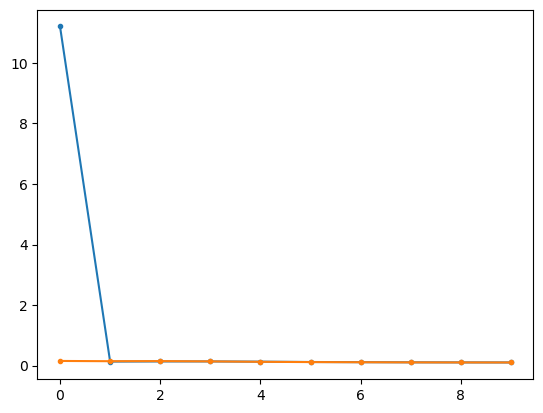

In [21]:
plt.plot(np.arange(10), training_loss, label='Train', marker='.')
plt.plot(np.arange(10), validation_loss, label='Validation', marker='.')
plt.show()

In [22]:
unique_test_phages = test_ids['PhageID'].unique()
unique_test_bacteria = test_ids['HostID'].unique()

test_phage_dataset = TestDataset(unique_test_phages, phage_embed_dict)
test_bact_dataset = TestDataset(unique_test_bacteria, bact_embed_dict)
phage_loader = DataLoader(test_phage_dataset, batch_size=int(len(test_phage_dataset)/2))
bact_loader = DataLoader(test_bact_dataset, batch_size=int(len(test_bact_dataset)/2))

phage_ids, output_phage_embeddings = predict(phage_loader, phage_encoder)
print(phage_ids.shape)
print(output_phage_embeddings.shape)

bact_ids, output_bact_embeddings = predict(bact_loader, bacteria_encoder)
print(bact_ids.shape)
print(output_bact_embeddings.shape)

(2427,)
(2427, 512)
(280,)
(280, 512)


In [31]:
output_phage_embeddings

array([[ 0.05159364,  0.01838498, -0.00373273, ..., -0.02024688,
         0.03140847, -0.01486102],
       [ 0.00921706, -0.00703142, -0.0433768 , ..., -0.01726251,
         0.00052048, -0.01965614],
       [ 0.02849849,  0.02578037, -0.00652847, ...,  0.00735323,
         0.01421917, -0.02216879],
       ...,
       [-0.02107823, -0.00793231,  0.03314677, ...,  0.01797125,
         0.01264664, -0.02616333],
       [ 0.01236111,  0.04548113,  0.01345567, ...,  0.05053048,
         0.02970124,  0.00577218],
       [ 0.03981574, -0.00798862,  0.00076907, ...,  0.02811551,
         0.01686788, -0.02740285]], dtype=float32)

In [33]:
output_bact_embeddings

array([[ 0.00313226, -0.02733641,  0.02353398, ..., -0.02207059,
        -0.03339071,  0.0185273 ],
       [ 0.00313226, -0.02733641,  0.02353398, ..., -0.02207059,
        -0.03339071,  0.0185273 ],
       [ 0.00313226, -0.02733641,  0.02353398, ..., -0.02207059,
        -0.03339071,  0.0185273 ],
       ...,
       [ 0.00313226, -0.02733641,  0.02353398, ..., -0.02207059,
        -0.03339071,  0.0185273 ],
       [ 0.00313226, -0.02733641,  0.02353398, ..., -0.02207059,
        -0.03339071,  0.0185273 ],
       [ 0.00313226, -0.02733641,  0.02353398, ..., -0.02207059,
        -0.03339071,  0.0185273 ]], dtype=float32)

In [41]:
get_neighbor_list(phage_ids, output_phage_embeddings, bact_ids, output_bact_embeddings)

(2427, 280)
[[  0 177 178 ...  89  95 279]
 [  0 177 178 ...  89  95 279]
 [  0 177 178 ...  89  95 279]
 ...
 [  0 177 178 ...  89  95 279]
 [  0 177 178 ...  89  95 279]
 [  0 177 178 ...  89  95 279]]
